In [17]:
#pip install pandas numpy scikit-learn matplotlib yfinance seaborn

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from graphing import graph_normal, show_results, graph_line
from results import get_num_correct_direction_difference
from get_data import get_apple_stock_split , get_recent_apple_stock_split

In [19]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

DAYS_LAG = 40

X_train, X_test, y_train, y_test = get_apple_stock_split(DAYS_LAG)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_Y.fit_transform(y_train)

X_test = scaler_X.transform(X_test)
y_test_scale = scaler_Y.transform(y_test)

[*********************100%***********************]  1 of 1 completed

Training samples: 1772, Testing samples: 444


<h1> GridSearch setup </h1>

In [20]:
# Define the different hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [None, 10, 20, 30],        # Maximum depth of trees
    'min_samples_split': [2, 5, 10],        # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples per leaf node
}

In [21]:
#training
model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_squared_error',         # Use mse as scoring
    verbose=4,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, y_train.ravel())

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [22]:
show_results(grid_search.cv_results_)

Rank 1:
Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean Test Score: -1.0250
Std Dev of Test Score: 0.0478
------------------------------
Rank 2:
Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Mean Test Score: -1.0293
Std Dev of Test Score: 0.0464
------------------------------
Rank 3:
Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean Test Score: -1.0303
Std Dev of Test Score: 0.0537
------------------------------
Rank 4:
Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Test Score: -1.0317
Std Dev of Test Score: 0.0518
------------------------------
Rank 5:
Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Mean Test Score: -1.0331
Std Dev of Test Score: 0.0490
------------------------------
Rank 6:
Parameters: {'max_depth': 10, 

In [23]:
# use best model to predict test data
final_model = grid_search.best_estimator_

# Predict on test data
predictions = scaler_Y.inverse_transform(final_model.predict(X_test).reshape(-1,1))
actual = scaler_Y.inverse_transform(y_test)

mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)

print(f"Final Model RMSE: {rmse}")
print(f"Final Model MAE: {mae}")

Final Model RMSE: 2.7909125580156897
Final Model MAE: 1.5742260097426786


[*********************100%***********************]  1 of 1 completed

RMSE: 3.5652301581458237
MAE: 2.722656813073709
mape: Price   Ticker
Target           NaN
dtype: float64


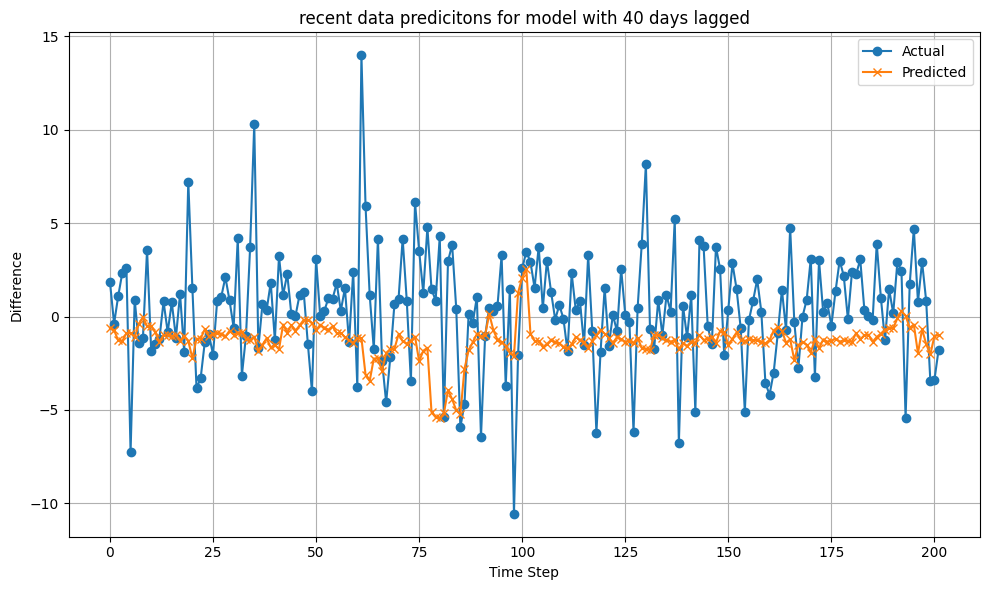

Price   Ticker
Target            79
dtype: int64 correct directions out of a total: 202


/mnt/c/Users/kenan/dev/university_final_year_project/venv_linux/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Price   Ticker
Target            79
dtype: int64

[CV 3/3] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=-1.158 total time=   4.1s
[CV 2/3] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-1.067 total time=  21.7s
[CV 3/3] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=-1.116 total time=  19.7s
[CV 2/3] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=-1.050 total time=   4.3s
[CV 2/3] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=-1.060 total time=   8.6s
[CV 1/3] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.968 total time=  16.1s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=-1.034 total time=   2.1s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=-0.959 total time=   7.5s
[CV 1/3] END max_depth=10, min_samples_

In [24]:
# trying to predict more recent ones
X, y = get_recent_apple_stock_split(DAYS_LAG)


X_scaled = scaler_X.transform(X)
predictions = scaler_Y.inverse_transform(grid_search.best_estimator_.predict(X_scaled).reshape(-1,1))

mae = mean_absolute_error(y, predictions)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
mape = np.abs((y - predictions)/y_test).mean() * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"mape: {mape}")
#graph_normal(predictions, y, "recent data predicitons")
graph_line(predictions, y, f"recent data predicitons for model with {DAYS_LAG} days lagged")
get_num_correct_direction_difference(predictions,y)